In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pudl
import pudl.constants as pc
import pudl.extract.ferc1

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 56

In [4]:
start_year = 2009
end_year = 2017
defaults = pudl.workspace.setup.get_defaults()
pudl_settings = pudl.workspace.setup.derive_paths(pudl_in=defaults["pudl_in"],
                                                  pudl_out=defaults["pudl_out"])
pudl_engine = pudl.init.connect_db(pudl_settings)
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine,
    freq="AS",
    start_date=pd.datetime(start_year, 1, 1),
    end_date=pd.datetime(end_year, 12, 31))
steam_ferc1 = pudl_out.plants_steam_ferc1()
fuel_ferc1 = pudl_out.fuel_ferc1().drop_duplicates(subset=['record_id'])
mcoe_df = pudl_out.mcoe()

/home/zane/miniconda3/envs/pudl/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [5]:
nf = pudl.transform.ferc1.fuel_by_plant_ferc1(fuel_ferc1)

In [6]:
key_cols = [
    'report_year',
    'utility_id_ferc1',
    'plant_name',
]
ferc_plants = (
    pd.merge(nf, steam_ferc1, on=key_cols, how='inner').
    assign(heat_rate_mmbtu_mwh=lambda x: x.fuel_mmbtu / x.net_generation_mwh).
    merge(steam_ferc1[key_cols+['utility_id_pudl', 'utility_name_ferc1','plant_id_pudl', 'plant_id_ferc1']]).
    query(f'report_year >= {start_year}')
)
ferc_coal_plants = ferc_plants.query("primary_fuel_by_mmbtu=='coal'")
ferc_gas_plants = ferc_plants.query("primary_fuel_by_mmbtu=='gas'")

eia_plants = mcoe_df.assign(report_year=lambda x: x.report_date.dt.year)
eia_coal_plants = eia_plants.query("fuel_type_code_pudl=='coal'")
eia_gas_plants = eia_plants.query("fuel_type_code_pudl=='gas'")

/home/zane/miniconda3/envs/pudl/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/zane/miniconda3/envs/pudl/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


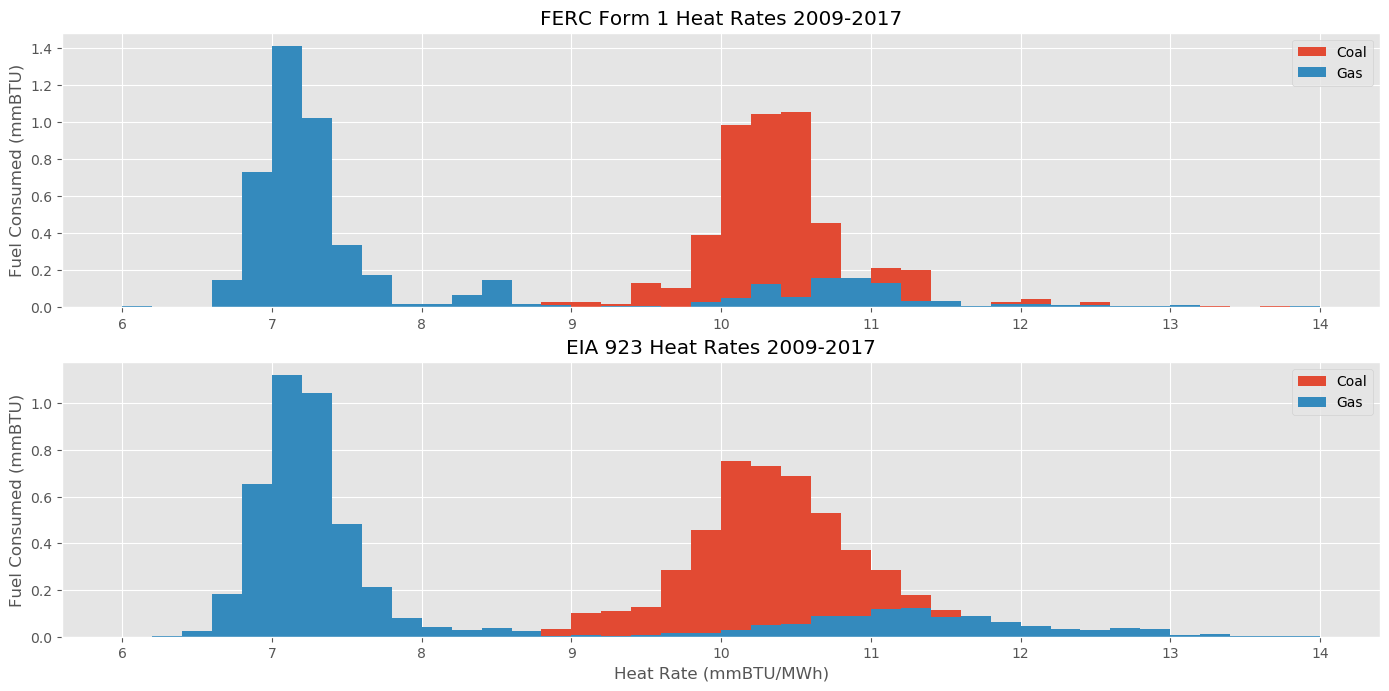

In [7]:
fig, (ferc_ax, eia_ax) = plt.subplots(ncols=1, nrows=2, figsize=(17,8))
ylabel = "Fuel Consumed (mmBTU)"
xlabel = "Heat Rate (mmBTU/MWh)"
hr_range = (6,14)
nbins=40
pdf=True

ferc_ax.hist(ferc_coal_plants.heat_rate_mmbtu_mwh,
             weights=ferc_coal_plants.net_generation_mwh,
             label="Coal", density=pdf, range=hr_range, bins=nbins)
ferc_ax.hist(ferc_gas_plants.heat_rate_mmbtu_mwh,
             weights=ferc_gas_plants.net_generation_mwh,
             label="Gas", density=pdf, range=hr_range, bins=nbins)
ferc_ax.set_ylabel(ylabel)
ferc_ax.set_title("FERC Form 1 Heat Rates 2009-2017")
ferc_ax.legend()

eia_ax.hist(eia_coal_plants.heat_rate_mmbtu_mwh,
            weights=eia_coal_plants.net_generation_mwh,
            label="Coal", density=pdf, range=hr_range, bins=nbins)
eia_ax.hist(eia_gas_plants.heat_rate_mmbtu_mwh,
            weights=eia_gas_plants.net_generation_mwh,
            label="Gas", density=pdf, range=hr_range, bins=nbins)
eia_ax.set_ylabel(ylabel)
eia_ax.set_xlabel(xlabel)
eia_ax.set_title("EIA 923 Heat Rates 2009-2017")
eia_ax.legend()

plt.show()

## Comparing FERC & EIA Fuel Costs (\$/MWh), Grouped by PUDL Plant + Fuel

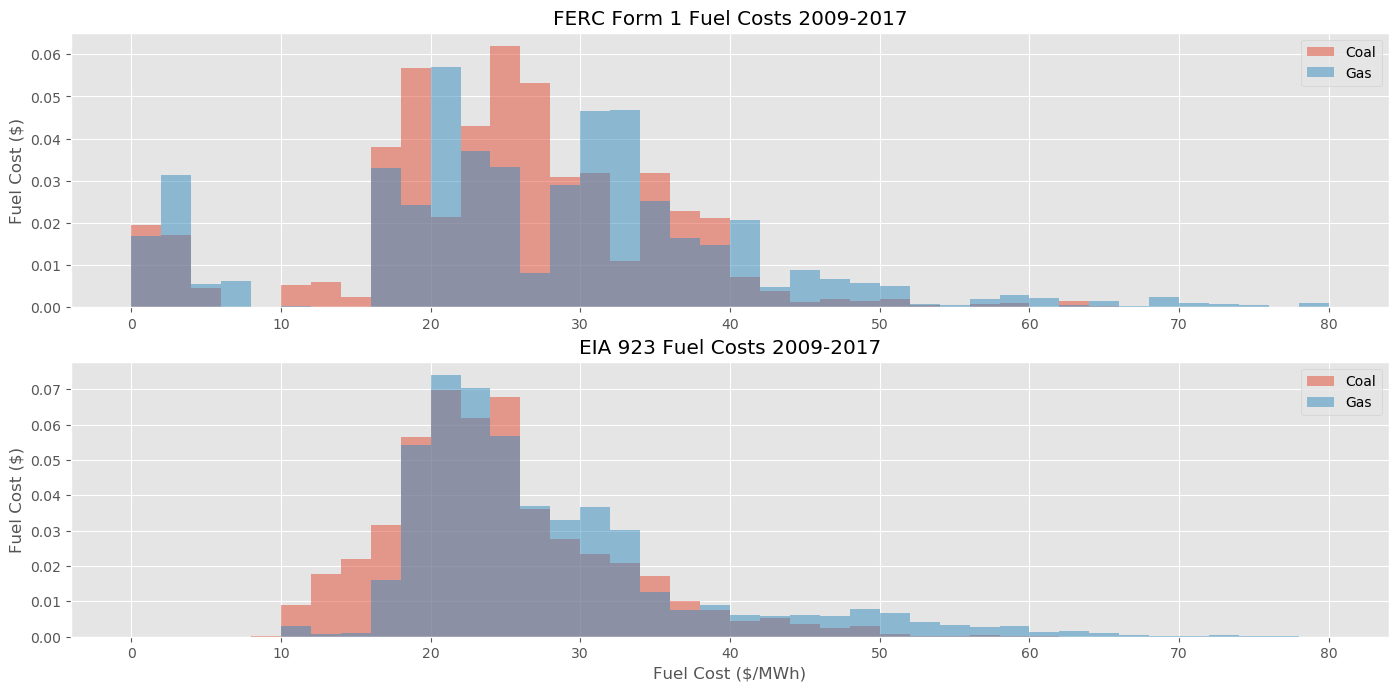

In [8]:
fig, (ferc_ax, eia_ax) = plt.subplots(ncols=1, nrows=2, figsize=(17,8))
xlabel = "Fuel Cost ($/MWh)"
ylabel = "Fuel Cost ($)"
cost_range = (0,80)
nbins=40
pdf=True

ferc_ax.hist((ferc_coal_plants.opex_fuel/ferc_coal_plants.net_generation_mwh), range=cost_range, bins=nbins, weights=ferc_coal_plants.net_generation_mwh, label="Coal", density=pdf, alpha=0.5)
ferc_ax.hist((ferc_gas_plants.opex_fuel/ferc_gas_plants.net_generation_mwh), range=cost_range, bins=nbins, weights=ferc_gas_plants.net_generation_mwh, label="Gas", density=pdf, alpha=0.5)
ferc_ax.set_ylabel(ylabel)
ferc_ax.set_title("FERC Form 1 Fuel Costs 2009-2017")
ferc_ax.legend()

eia_ax.hist((eia_coal_plants.fuel_cost_per_mwh), range=cost_range, bins=nbins, weights=eia_coal_plants.net_generation_mwh, label="Coal", density=pdf, alpha=0.5)
eia_ax.hist((eia_gas_plants.fuel_cost_per_mwh), range=cost_range, bins=nbins, weights=eia_gas_plants.net_generation_mwh, label="Gas", density=pdf, alpha=0.5)
eia_ax.set_ylabel(ylabel)
eia_ax.set_xlabel(xlabel)
eia_ax.set_title("EIA 923 Fuel Costs 2009-2017")
eia_ax.legend()

plt.show()

## PUDL Plant + Fuel Level EIA/FERC Agreement in Annual Heat Rates
 * Merge FERC & MCOE on [`report_year`, `fuel_type_code_pudl`, `plant_id_pudl`]
 
Stuff to plot (Annual):
 * Total Fuel Cost (\$)
 * Total Heat Content (mmBTU)
 * Total Net Generation (MWh)
 * Total Capacity (MW)
 * Fuel Cost (\$/MWh)
 * Fuel Cost (\$/mmBTU)
 * Heat Rate (mmBTU/MWh)
 * Capacity Factor

In [9]:
pudl_plant_cols = [
    'plant_id_pudl',
    'primary_fuel_by_mmbtu',
    'report_year',
]
eia_dude = (
    eia_plants.
    rename(columns={'total_fuel_cost': 'opex_fuel',
                    'fuel_type_code_pudl': 'primary_fuel_by_mmbtu'}).
    groupby(pudl_plant_cols)['net_generation_mwh',
                             'capacity_mw',
                             'opex_fuel',
                             'total_mmbtu'].
    agg(sum).reset_index().
    assign(fuel_cost_per_mwh=lambda x: x.opex_fuel / x.net_generation_mwh).
    assign(fuel_cost_per_mmbtu=lambda x: x.opex_fuel / x.total_mmbtu).
    assign(heat_rate_mmbtu_mwh=lambda x: x.total_mmbtu / x.net_generation_mwh).
    assign(capacity_factor=lambda x: x.net_generation_mwh / (8760*x.capacity_mw))
)
ferc_dude = (
    ferc_plants.
    rename(columns={'fuel_mmbtu': 'total_mmbtu'}).
    groupby(pudl_plant_cols)['net_generation_mwh',
                             'capacity_mw',
                             'opex_fuel',
                             'opex_production_total',
                             'total_mmbtu'].
    agg(sum).reset_index().
    assign(opex_nonfuel_ferc=lambda x: x.opex_production_total - x.opex_fuel).
    drop('opex_production_total', axis=1).
    assign(fuel_cost_per_mwh=lambda x: x.opex_fuel / x.net_generation_mwh).
    assign(fuel_cost_per_mmbtu=lambda x: x.opex_fuel / x.total_mmbtu).
    assign(heat_rate_mmbtu_mwh=lambda x: x.total_mmbtu / x.net_generation_mwh).
    assign(capacity_factor=lambda x: x.net_generation_mwh / (8760*x.capacity_mw))
)
pudl_dude = pd.merge(ferc_dude, eia_dude, suffixes=('_ferc', '_eia'), on=pudl_plant_cols)

In [10]:
def plot_eia_v_ferc(df, fields_to_plot, xy_limits):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for field in fields_to_plot:
        field_eia = field+'_eia'
        field_ferc = field+'_ferc'
        fig, (coal_ax, gas_ax) = plt.subplots(ncols=2, nrows=1, figsize=(11, 5))
        
        coal_ax.scatter(df.query("primary_fuel_by_mmbtu=='coal'")[field_eia],
                        df.query("primary_fuel_by_mmbtu=='coal'")[field_ferc],
                        color='black', alpha='0.1', label=field)
        coal_ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
        coal_ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
        coal_ax.set_xlabel('EIA')
        coal_ax.set_ylabel('FERC')
        coal_ax.set_title(f"{field} (Coal)")
        
        gas_ax.scatter(df.query("primary_fuel_by_mmbtu=='gas'")[field_eia],
                       df.query("primary_fuel_by_mmbtu=='gas'")[field_ferc],
                       color='blue', alpha='0.1', label=field)
        gas_ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
        gas_ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
        gas_ax.set_xlabel('EIA')
        gas_ax.set_ylabel('FERC')
        gas_ax.set_title(f"{field} (Gas)")

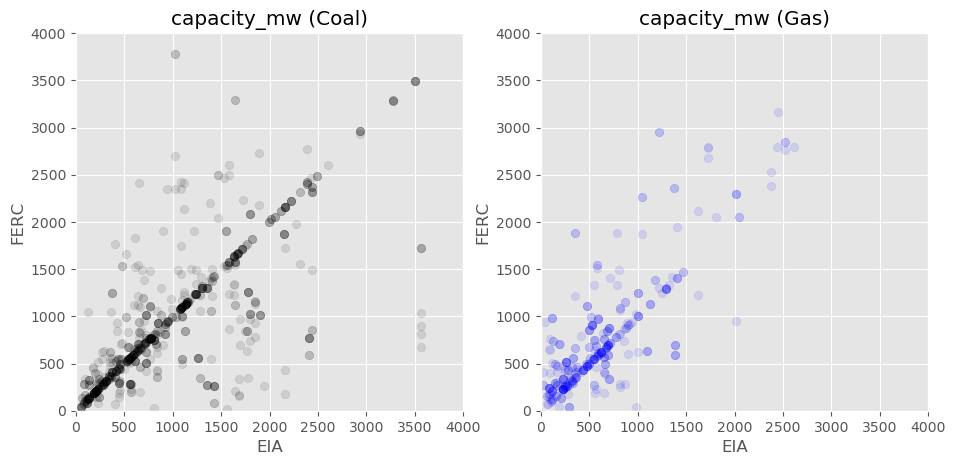

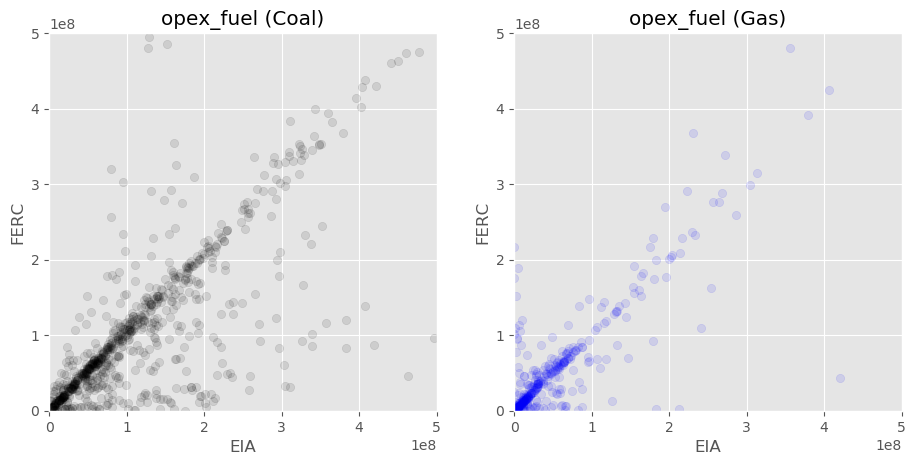

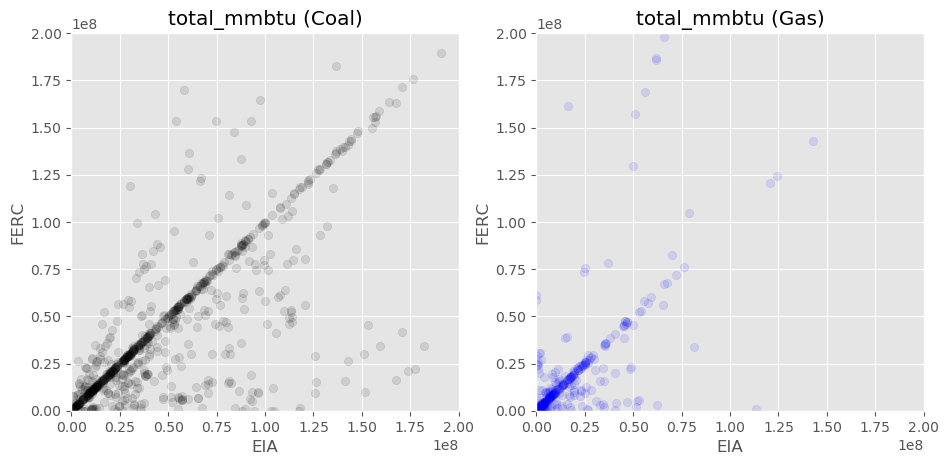

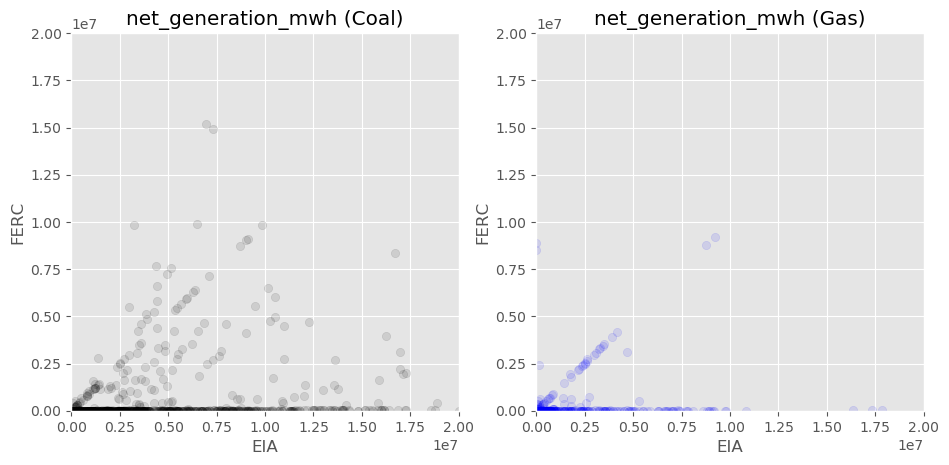

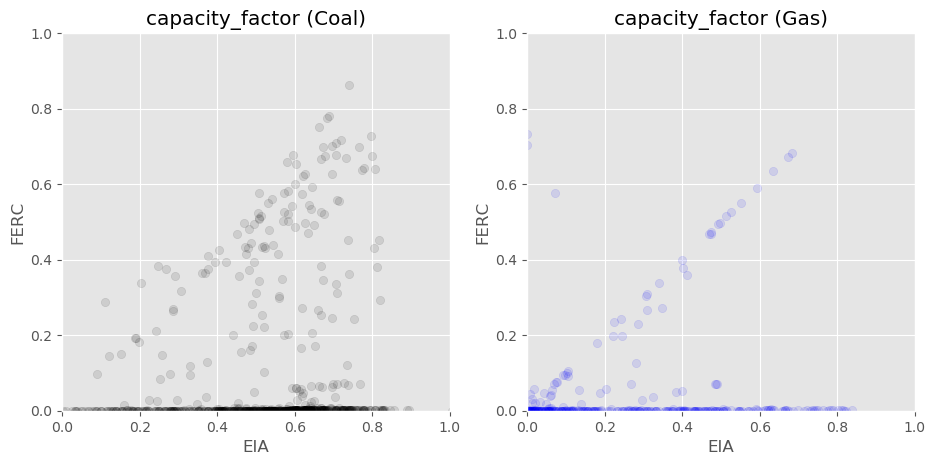

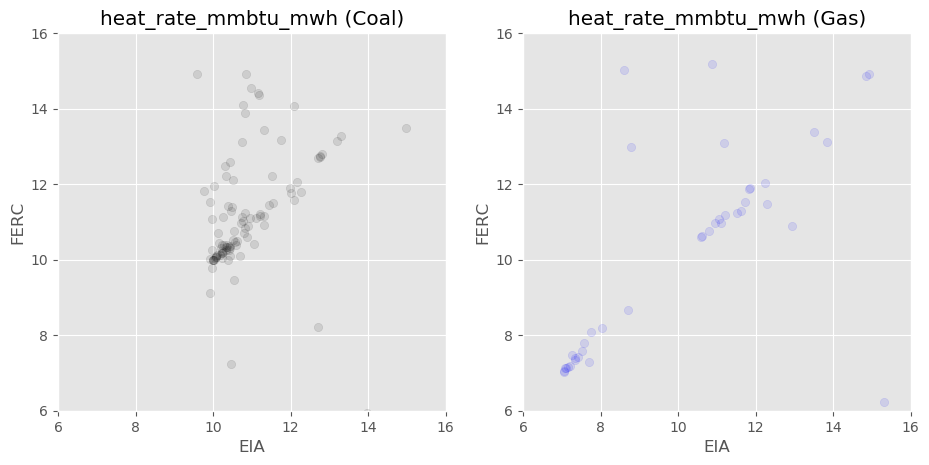

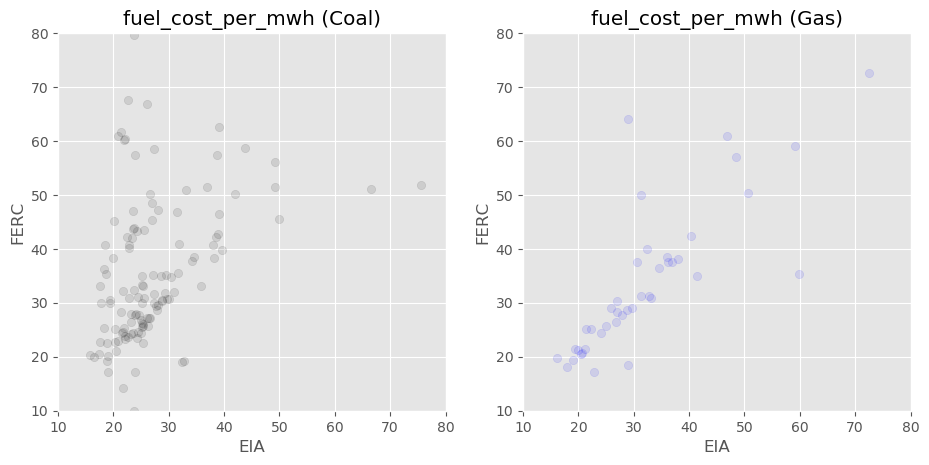

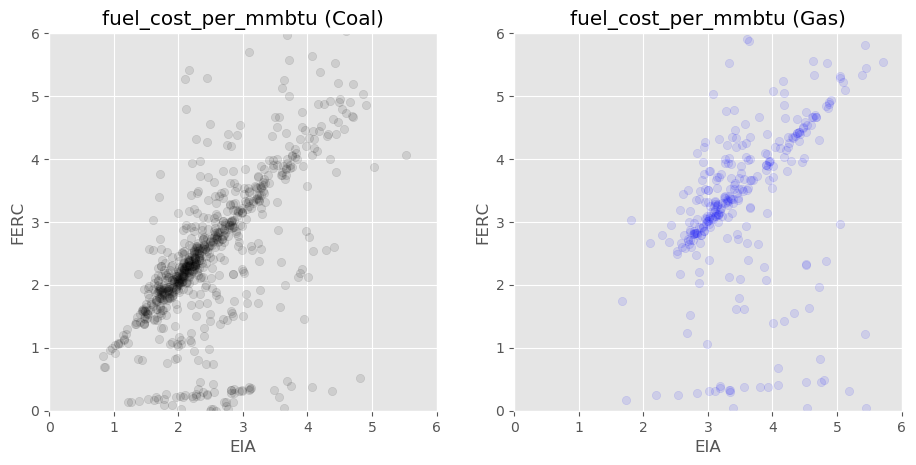

In [11]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    'opex_fuel',
    'total_mmbtu',
    'net_generation_mwh',
    # Derived values
    'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (0,4000),
    'opex_fuel': (0,5e8),
    'total_mmbtu': (0,2e8),
    'net_generation_mwh': (0,2e7),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (0,6),
}

plot_eia_v_ferc(pudl_dude, fields_to_plot, xy_limits)